In [1]:
import pandas as pd
import numpy as np
import xarray as xr

import scipy.stats as stats
import matplotlib.pyplot as plt

import boto3
from io import BytesIO

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [21]:
# testing file
file = xr.open_dataset('/Users/victoriaford/Desktop/Train_Files/ASOSAWOS_72051724165.nc') # has flagged vars
df = file.to_dataframe()

/Users/victoriaford/anaconda3/envs/histobs/lib/python3.11/site-packages/pandas/core/arrays/timedeltas.py:908: RuntimeWarning: invalid value encountered in cast
  base = data.astype(np.int64)
/Users/victoriaford/anaconda3/envs/histobs/lib/python3.11/site-packages/pandas/core/arrays/timedeltas.py:912: RuntimeWarning: invalid value encountered in cast
  data = (base * m + (frac * m).astype(np.int64)).view("timedelta64[ns]")


In [22]:
def _plot_format_helper(var):
    """Helper function for plots"""

    pr_vars = ['pr', 'pr_5min', 'pr_1h', 'pr_24h', 'pr_localmid']
    ps_vars = ['ps', 'psl', 'psl_altimeter']
    
    if var == 'tas':
        ylab = 'Air Temperature at 2m'
        unit = 'K'
        
    elif var == 'tdps' or var == 'tdps_derived':
        ylab = 'Dewpoint Temperature'
        unit = 'K'
        
    elif var == 'sfcWind':
        ylab = 'Surface Wind Speed'
        unit = '${m s^-1}$'
        
    elif var == 'sfcWind_dir':
        ylab = 'Surface Wind Direction'
        unit = 'degrees'
        
    elif var == 'rsds':
        ylab = 'Surface Radiation'
        unit = '${W m^-2}$'
        
    elif var in pr_vars:
        ylab = 'Precipitation' # should be which precip var it is
        unit = 'mm'

    elif var in ps_vars:
        ylab = 'Pressure' # should eventually be what pressure var it is
        unit = 'Pa'
        
    return (ylab, unit)


def monthly_med(df):
    """Calculates the monthly median"""
    return df.resample('M', on='time').median(numeric_only=True)


def iqr_range(df, month, var):
    """Calculates the monthly interquartile range"""
    q1 = df.groupby('month').quantile(0.25, numeric_only=True)
    q3 = df.groupby('month').quantile(0.75, numeric_only=True)
    iqr_df = q3 - q1
    
    iqr_val = iqr_df.loc[iqr_df.index == month]
    
    # inflated to 4°C or 4 hPa for months with very small IQR
    var_check = ['tas', 'tdps', 'tdps_derived', 'ps', 'psl', 'psl_altimeter']
    if iqr_val[var].values < 4:
        if var in var_check:
            iqr_val[var].values = 4
    
    return iqr_val[var].values

def standardized_anom(df, month, var):
    """
    Calculates the monthly anomalies standardized by IQR range
    
    Returns:
        arr_std_anom: array of monthly standardized anomalies for var
    """
    
    df_monthly_med = monthly_med(df)
    df_clim_med = clim_med(df)
    
    arr_anom = (df_monthly_med.loc[df_monthly_med['month'] == month][var].values -
                df_clim_med.loc[df_clim_med.index == month][var].values)
        
    arr_std_anom = arr_anom / iqr_range(df, month, var)
    
    return arr_std_anom
    
def standardized_median_bounds(df, month, var, iqr_thresh=5):
    """Calculates the standardized median"""
    std_med = df.loc[df['month'] == month][var].median() # climatological median for that month
    
    lower_bnd = std_med - (iqr_thresh * iqr_range(df, month, var))
    upper_bnd = std_med + (iqr_thresh * iqr_range(df, month, var))
    
    return (std_med, lower_bnd[0], upper_bnd[0])

In [23]:
def qaqc_dist_whole_stn_bypass_check(df, vars_to_check, min_num_months=5):
    """
    Checks the number of valid observation months in order to proceed through 
    monthly distribution checks. Identifies whether a station record has too 
    few months and produces a fail pass flag. 
    """
    
    # set up df
    df = df.reset_index() 
    df['month'] = pd.to_datetime(df['time']).dt.month # sets month to new variable
    df['year'] = pd.to_datetime(df['time']).dt.year # sets year to new variable
             
    # set up a "pass_flag" to determine if station proceeds through distribution function
    pass_flag = 'pass'
    
    for var in vars_to_check:
        # add _eraqc column for each variable
        df[var+'_eraqc'] = np.nan # default value of nan    
    
        for month in range(1,13):

            # first check num of months in order to continue
            month_to_check = df.loc[df['month'] == month]

            # check for number of obs years
            if (len(month_to_check.year.unique()) < 5):
                df[var+'_eraqc'] = 18 # see era_qaqc_flag_meanings.csv
                pass_flag = 'fail'

    err_statement = '{} has too short of an observation record to proceed through the monthly distribution qa/qc checks -- bypassing station'.format(
                    df['station'].unique()[0])
    
    if pass_flag == 'fail':
        print(err_statement)
                
    return (df, pass_flag) 


def qaqc_dist_var_bypass_check(df, vars_to_check, min_num_months=5):
    """
    Checks the number of valid observation months per variable
    to proceed through monthly distribution checks.
    Primarily assesses whether if null values persist for a month
    """
        
    for var in vars_to_check:
        for month in range(1,13):
            monthly_df = df.loc[df['month']==month]
            
            # if all values are null for that month across years
            if monthly_df[var].isnull().all() == True:
                df[var+'_eraqc'] = 19 # see era_qaqc_flag_meanings.csv
            
            # if not all months have nans, need to assess how many years do
            elif monthly_med(df).loc[monthly_med(df)['month'] == month][var].isna().sum() > min_num_months:
#                 print('{} has less than {} months of valid {} observations -- bypassing check'.format(
#                 df['station'].unique()[0], min_num_months, var))
                
                df[var+'_eraqc'] = 19 # see era_qaqc_flag_meanings.csv
        
    return df

In [24]:
def qaqc_dist_gaps_part1(df, iqr_thresh=5, plot=True):
    """
    Part 1 / monthly check
        - compare anomalies of monthly median values
        - standardize against interquartile range
        - compare stepwise from the middle of the distribution outwards
        - asymmetries are identified and flagged if severe
    Goal: identifies suspect months and flags all obs within month
    
    NOTE: Code is preliminary at present, and does not necessarily reflect the final IQR threshold 
    """
    
    # run through every var, excluding qaqc/duration/method vars
    vars_to_remove = ['index','station','qc','duration','method','lat','lon','elevation','time','month','year','sfcWind_dir'] # list of var substrings to exclude if present in var
    vars_to_check = [var for var in df.columns if not any(True for item in vars_to_remove if item in var)] # remove all non-primary variables
        
    # whole station bypass check first
    df, pass_flag = qaqc_dist_whole_stn_bypass_check(df, vars_to_check)
    
    if pass_flag != 'fail':
        
        for var in vars_to_check:
            for month in range(1,13):
                
                # per variable bypass check
                df = qaqc_dist_var_bypass_check(df, vars_to_check) # flag here is 19
                if 19 in df[var+'_eraqc']:
                    continue # skip variable 
                
                # station has above min_num_months number of valid observations, proceed with dist gap check
                else:
                    # calculate monthly climatological median, and bounds
                    mid, low, high = standardized_median_bounds(df, month, var, iqr_thresh=iqr_thresh)

                    # calculate monthly median per month
                    df_month = monthly_med(df)

                    for i in df_month.loc[df_month['month'] == month][var]:
                        if (i < low) or (i > high):
                            year_to_flag = (df_month.loc[(df_month[var]==i) & 
                                               (df_month['month']==month)]['year'].values[0])
                            print('Median {} value for {}-{} is beyond the {}*IQR limits -- flagging month'.format(
                                var,
                                month, 
                                int(year_to_flag),
                                iqr_thresh)
                            )

                            # flag all obs in that month
                            df.loc[(df['month']==month) & 
                                   (df['year']==year_to_flag), var+'_eraqc'] = 20 # see era_qaqc_flag_meanings.csv

        if plot==True:
            for month in range(1,13):
                for var in vars_to_check:
                    if 19 not in df[var+'_eraqc'].values: # don't plot a figure if it's all nans/not enough months
                        dist_gap_part1_plot(df, month, var, flagval=20, iqr_thresh=iqr_thresh,
                                            network=df['station'].unique()[0].split('_')[0])
                
    return df

In [25]:
def dist_gap_part1_plot(df, month, var, flagval, iqr_thresh, network):
        
    # grab data by months
    df = df.loc[df['month'] == month]
        
    # grab flagged data
    flag_vals = df.loc[df[var + '_eraqc'] == flagval]
    
    # plot valid data
    ax = df.plot.scatter(x='time', y=var, label='Pass')
    
    # plot flagged data
    flag_vals.plot.scatter(ax=ax, x='time', y=var, color='r', label='Flagged')
    # should be consistent with other plots - I like Hector's open circles around flagged values

    # plot climatological median and threshold * IQR range
    mid, low_bnd, high_bnd = standardized_median_bounds(df, month, var, iqr_thresh=5)
    
    plt.axhline(y=mid, color='k', lw=0.5, label='Climatological monthly median')
    plt.fill_between(x=df['time'],
                    y1=low_bnd,
                    y2=high_bnd,
                    alpha=0.25, color='0.75', 
                    label='{} * IQR range'.format(iqr_thresh))
    
    # plot aesthetics
    plt.legend(loc='best')
    ylab = _plot_format_helper(var)
    plt.ylabel('{} [{}]'.format(ylab[0], ylab[1]));
    plt.xlabel('')
    plt.title('Distribution gap check pt 1: {0} / month: {1}'.format(
        df['station'].unique()[0],
        month), 
              fontsize=10);
    
    # save to AWS
    bucket_name = 'wecc-historical-wx'
    directory = '3_qaqc_wx'
    img_data = BytesIO()
    plt.savefig(img_data, format='png')
    img_data.seek(0)
    
    s3 = boto3.resource('s3')
    bucket = s3.Bucket(bucket_name)
    figname = 'qaqc_dist_gap_check_part1_{0}_{1}_{2}'.format(df['station'].unique()[0], var, month)
    bucket.put_object(Body=img_data, ContentType='image/png',
                 Key='{0}/{1}/qaqc_figs/{2}.png'.format(
                 directory, network, figname))
    
    # close figures to save memory
    plt.close()

UnboundLocalError: cannot access local variable 'ylab' where it is not associated with a value

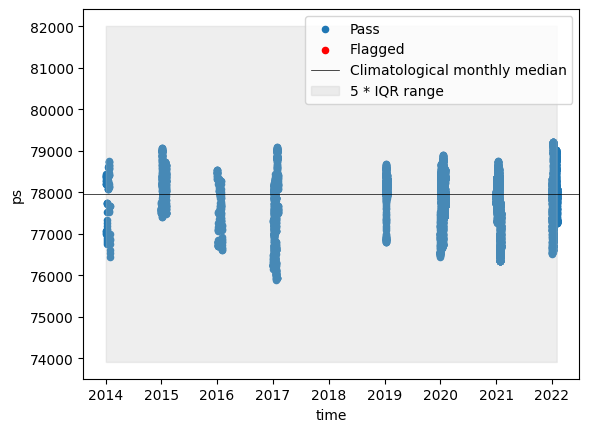

In [26]:
qaqc_dist_gaps_part1(df)